In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tqdm

In [4]:
label_class = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

def plot_image(image, label):
    plt.figure()
    plt.imshow(image)
    plt.xlabel(label_class[label.numpy()])

In [5]:
def prepare_dataset(input_ds):
    # cast datatype to float
    ds = input_ds.map(lambda img, target: (tf.cast(img, tf.float32), target))

    # normalize values
    ds = ds.map(lambda img, target: (img/128. - 1., target))

    # convert target to one-hot vector
    ds = ds.map(lambda img, target: (img, tf.one_hot(target, depth=10)))

    ds = ds.shuffle(1000)
    ds = ds.batch(32)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds

In [6]:
def get_dataset():
    (train_dataset, test_dataset), ds_info = tfds.load(
        "cifar10", split=["train", "test"], as_supervised=True, with_info=True
    )

    train_ds = prepare_dataset(train_dataset)
    test_ds = prepare_dataset(test_dataset)

    return (train_ds, test_ds)


In [7]:
(train_dataset, test_dataset), ds_info = tfds.load(
    "cifar10", split=["train", "test"], as_supervised=True, with_info=True
)

train_ds = prepare_dataset(train_dataset)
test_ds = prepare_dataset(test_dataset)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incomplete9NUE83/cifar10-train.tfrecord*...:   0%|          | 0/…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incomplete9NUE83/cifar10-test.tfrecord*...:   0%|          | 0/1…

Dataset cifar10 downloaded and prepared to ~/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


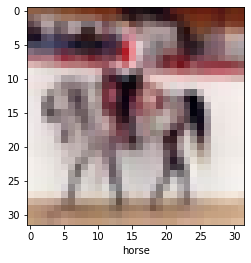

In [8]:
# visualize sample
image, label = next(iter(train_dataset))
plot_image(image, label)

In [9]:
class Cifar10CNN(tf.keras.Model):
    def __init__(self, optimizer):
        # initialize superclass
        super().__init__()
        self.optimizer = optimizer

        self.metrics_list = [
            tf.keras.metrics.Mean(name="loss"),
            tf.keras.metrics.CategoricalAccuracy()
        ]

        self.loss_function = tf.keras.losses.BinaryCrossentropy()

        # declare layers
        self.conv1 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding="same", activation="relu")
        self.conv2 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding="same", activation="relu")
        self.pooling = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        self.conv3 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding="same", activation="relu")
        self.conv4 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding="same", activation="relu")
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()

        self.out = tf.keras.layers.Dense(10, activation="softmax")


    @tf.function
    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pooling(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.global_pool(x)
        x = self.out(x)
        return x


    @property
    def metrics(self):
        return self.metrics_list


    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()


    def train_step(self, data):
        img, label = data

        with tf.GradientTape() as tape:
            output = self(img)
            loss = self.loss_function(label, output)
        
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients,
                                           self.trainable_variables))

        self.metrics[0].update_state(loss)
        self.metrics[1].update_state(output, label)

        return {m.name: m.result() for m in self.metrics}


    def test_step(self, data):
        img, label = data
        output = self(img)
        loss = self.loss_function(label, output)

        self.metrics[0].update_state(loss)
        self.metrics[1].update_state(output, label)

        return {f"val_{m.name}": m.result() for m in self.metrics}

In [10]:
def train_model(model):
    train_ds, test_ds = get_dataset()

    train_metrics = []
    val_metrics = []

    for e in range(15):
        for data in tqdm.tqdm(train_ds):
            metrics = model.train_step(data)
        
        for name, value in metrics.items():
            print(f"Epoch {e}: {name}: {value}")

        train_metrics.append(metrics)
        model.reset_metrics()

        for data in test_ds:
            metrics = model.test_step(data)
        
        for name, value in metrics.items():
            print(f"Epoch {e}: {name}: {value}")
        
        val_metrics.append(metrics)
        model.reset_metrics()
    
    return (train_metrics, val_metrics)

In [11]:
optimizer = tf.keras.optimizers.Adam()

model = Cifar10CNN(optimizer)

train_metrics, val_metrics = train_model(model)

100%|██████████| 1563/1563 [00:42<00:00, 36.59it/s]


Epoch 0: loss: 0.2538202106952667
Epoch 0: categorical_accuracy: 0.3692399859428406
Epoch 0: val_loss: 0.22493816912174225
Epoch 0: val_categorical_accuracy: 0.46639999747276306


100%|██████████| 1563/1563 [00:25<00:00, 61.21it/s]


Epoch 1: loss: 0.2098129391670227
Epoch 1: categorical_accuracy: 0.5146399736404419
Epoch 1: val_loss: 0.19927409291267395
Epoch 1: val_categorical_accuracy: 0.5364999771118164


100%|██████████| 1563/1563 [00:25<00:00, 62.16it/s]


Epoch 2: loss: 0.187464639544487
Epoch 2: categorical_accuracy: 0.5792199969291687
Epoch 2: val_loss: 0.1790168732404709
Epoch 2: val_categorical_accuracy: 0.6021999716758728


100%|██████████| 1563/1563 [00:25<00:00, 61.04it/s]


Epoch 3: loss: 0.1726059764623642
Epoch 3: categorical_accuracy: 0.6180800199508667
Epoch 3: val_loss: 0.16430442035198212
Epoch 3: val_categorical_accuracy: 0.6352999806404114


100%|██████████| 1563/1563 [00:25<00:00, 62.33it/s]


Epoch 4: loss: 0.1633157879114151
Epoch 4: categorical_accuracy: 0.6412799954414368
Epoch 4: val_loss: 0.1561531275510788
Epoch 4: val_categorical_accuracy: 0.6574000120162964


100%|██████████| 1563/1563 [00:25<00:00, 61.53it/s]


Epoch 5: loss: 0.15516477823257446
Epoch 5: categorical_accuracy: 0.6625800132751465
Epoch 5: val_loss: 0.15767645835876465
Epoch 5: val_categorical_accuracy: 0.649399995803833


100%|██████████| 1563/1563 [00:25<00:00, 62.13it/s]


Epoch 6: loss: 0.1488114595413208
Epoch 6: categorical_accuracy: 0.6781399846076965
Epoch 6: val_loss: 0.1496085524559021
Epoch 6: val_categorical_accuracy: 0.6758000254631042


100%|██████████| 1563/1563 [00:25<00:00, 61.28it/s]


Epoch 7: loss: 0.14396394789218903
Epoch 7: categorical_accuracy: 0.6890400052070618
Epoch 7: val_loss: 0.15634684264659882
Epoch 7: val_categorical_accuracy: 0.6600000262260437


100%|██████████| 1563/1563 [00:25<00:00, 62.02it/s]


Epoch 8: loss: 0.1386851817369461
Epoch 8: categorical_accuracy: 0.7031400203704834
Epoch 8: val_loss: 0.1402665078639984
Epoch 8: val_categorical_accuracy: 0.6988999843597412


100%|██████████| 1563/1563 [00:25<00:00, 61.95it/s]


Epoch 9: loss: 0.13432054221630096
Epoch 9: categorical_accuracy: 0.7129200100898743
Epoch 9: val_loss: 0.1383185088634491
Epoch 9: val_categorical_accuracy: 0.7009999752044678


100%|██████████| 1563/1563 [00:25<00:00, 61.55it/s]


Epoch 10: loss: 0.1304161250591278
Epoch 10: categorical_accuracy: 0.7231000065803528
Epoch 10: val_loss: 0.13610796630382538
Epoch 10: val_categorical_accuracy: 0.7106000185012817


100%|██████████| 1563/1563 [00:25<00:00, 61.61it/s]


Epoch 11: loss: 0.1266501247882843
Epoch 11: categorical_accuracy: 0.7318800091743469
Epoch 11: val_loss: 0.12909333407878876
Epoch 11: val_categorical_accuracy: 0.7293999791145325


100%|██████████| 1563/1563 [00:25<00:00, 61.71it/s]


Epoch 12: loss: 0.12296299636363983
Epoch 12: categorical_accuracy: 0.7416800260543823
Epoch 12: val_loss: 0.13297970592975616
Epoch 12: val_categorical_accuracy: 0.7164000272750854


100%|██████████| 1563/1563 [00:25<00:00, 61.57it/s]


Epoch 13: loss: 0.1202113926410675
Epoch 13: categorical_accuracy: 0.7477800250053406
Epoch 13: val_loss: 0.12673190236091614
Epoch 13: val_categorical_accuracy: 0.7297000288963318


100%|██████████| 1563/1563 [00:24<00:00, 62.52it/s]


Epoch 14: loss: 0.11719711869955063
Epoch 14: categorical_accuracy: 0.7549399733543396
Epoch 14: val_loss: 0.12563304603099823
Epoch 14: val_categorical_accuracy: 0.736299991607666


Text(0, 0.5, 'val_Accuracy')

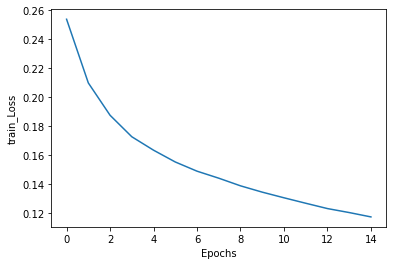

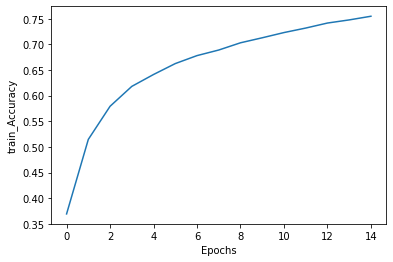

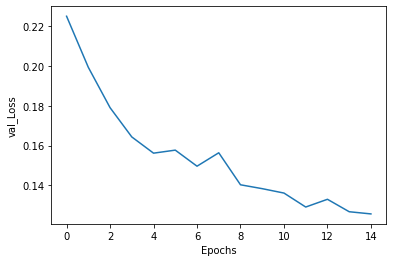

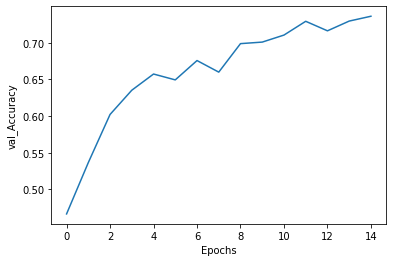

In [12]:
train_loss = [train_metric["loss"] for train_metric in train_metrics]
train_accuracy = [train_metric["categorical_accuracy"] for train_metric in train_metrics]
val_loss = [val_metric["val_loss"] for val_metric in val_metrics]
val_accuracy = [val_metric["val_categorical_accuracy"] for val_metric in val_metrics]

plt.figure()
plt.plot(train_loss)
plt.xlabel("Epochs")
plt.ylabel("train_Loss")

plt.figure()
plt.plot(train_accuracy)
plt.xlabel("Epochs")
plt.ylabel("train_Accuracy")

plt.figure()
plt.plot(val_loss)
plt.xlabel("Epochs")
plt.ylabel("val_Loss")

plt.figure()
plt.plot(val_accuracy)
plt.xlabel("Epochs")
plt.ylabel("val_Accuracy")
